In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lipreading/data/s1/bwam9s.mpg
/kaggle/input/lipreading/data/s1/lgbm4p.mpg
/kaggle/input/lipreading/data/s1/bbizzn.mpg
/kaggle/input/lipreading/data/s1/srwo6n.mpg
/kaggle/input/lipreading/data/s1/bgbu3s.mpg
/kaggle/input/lipreading/data/s1/pwax6p.mpg
/kaggle/input/lipreading/data/s1/srwb8n.mpg
/kaggle/input/lipreading/data/s1/sgic1a.mpg
/kaggle/input/lipreading/data/s1/sgbp6p.mpg
/kaggle/input/lipreading/data/s1/sbwo2p.mpg
/kaggle/input/lipreading/data/s1/srit9s.mpg
/kaggle/input/lipreading/data/s1/sgio6n.mpg
/kaggle/input/lipreading/data/s1/srah6p.mpg
/kaggle/input/lipreading/data/s1/prip2p.mpg
/kaggle/input/lipreading/data/s1/sbinzp.mpg
/kaggle/input/lipreading/data/s1/bgaa6n.mpg
/kaggle/input/lipreading/data/s1/pgak2n.mpg
/kaggle/input/lipreading/data/s1/pgwe7s.mpg
/kaggle/input/lipreading/data/s1/bgit7a.mpg
/kaggle/input/lipreading/data/s1/pbwp6n.mpg
/kaggle/input/lipreading/data/s1/bgwb4n.mpg
/kaggle/input/lipreading/data/s1/swbczn.mpg
/kaggle/input/lipreading/data/s1

In [41]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [42]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [43]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

In [44]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab  

In [45]:
vocab=np.unique(get_vocab())

In [46]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

In [47]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [48]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [49]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [50]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4991664 ]
   [1.4991664 ]
   [1.4616872 ]
   ...
   [0.41227075]
   [0.41227075]
   [0.41227075]]

  [[1.4616872 ]
   [1.4616872 ]
   [1.4991664 ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  ...

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.11243747]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.11243747]
   [0.07495832]
   [0.07495832]]

  [[1.0494164 ]
   [1.0494164 ]
   [1.0119373 ]
   ...
   [0.07495832]
   [0.07495832]
   [0.03747916]]]


 [[[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.33731243]
   [0.33731243]
   [0.33731243]]

  [[1.424208  ]
   [1.424208  ]
   [1.424208  ]
   ...
   [0.29983327]
   [0.29983327]
   [0.29983327]]

  ...

  [[1.0494164 ]
   [

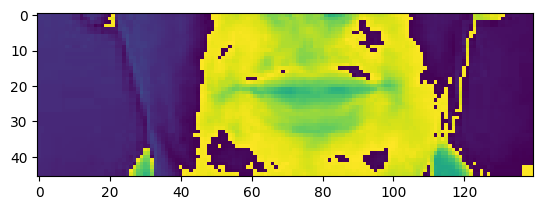

In [51]:
plt.imshow(frames[40])

In [52]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [53]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [54]:
frames, alighnments = data.as_numpy_iterator().next()

In [55]:
sample = data.as_numpy_iterator()

In [56]:
val = sample.next();val[0]

array([[[[[ 1.5227597 ],
          [ 1.5227597 ],
          [ 1.5227597 ],
          ...,
          [ 0.3342643 ],
          [ 0.29712382],
          [ 0.29712382]],

         [[ 1.5227597 ],
          [ 1.5227597 ],
          [ 1.5227597 ],
          ...,
          [ 0.3342643 ],
          [ 0.29712382],
          [ 0.29712382]],

         [[ 1.5227597 ],
          [ 1.5227597 ],
          [ 1.4113382 ],
          ...,
          [ 0.3714048 ],
          [ 0.29712382],
          [ 0.29712382]],

         ...,

         [[ 1.002793  ],
          [ 0.96565247],
          [ 0.96565247],
          ...,
          [ 0.03714048],
          [ 0.03714048],
          [ 0.03714048]],

         [[ 0.96565247],
          [ 0.96565247],
          [ 0.96565247],
          ...,
          [ 0.03714048],
          [ 0.        ],
          [ 0.        ]],

         [[ 0.96565247],
          [ 0.96565247],
          [ 0.96565247],
          ...,
          [ 0.03714048],
          [ 0.        ],
          

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [58]:
def scheduler(epoch,lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [59]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [60]:
def CTCLoss(y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [61]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [62]:
# checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
# schedule_callback = LearningRateScheduler(scheduler)
# example_callback = ProduceExample(test)

In [63]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [64]:
# model.fit(train,validation_data=test,epochs=1,callbacks=[checkpoint_callback,schedule_callback,example_callback])

In [65]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# # Load data from the file path
# frames, alignments = load_data(tf.convert_to_tensor(path))

# # Ensure the data matches the expected input shape
# frames = tf.reshape(frames, (1, 75, 46, 140, 1))

# # Predict using the model
# predictions = model.predict(frames)


In [66]:
# class AccuracyMetrics(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#         self.predictions = []
#         self.ground_truth = []

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
#         self.predictions.extend(decoded)
#         self.ground_truth.extend(data[1])

# # ... (your previous code)

# accuracy_metrics = AccuracyMetrics(test)  # Create an instance of AccuracyMetrics

# model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, accuracy_metrics])

# # After training, compute accuracy or any other metric using predictions and ground truth
# predictions = accuracy_metrics.predictions
# ground_truth = accuracy_metrics.ground_truth

# # Compute accuracy (or any other suitable metric) here
# # For example, using sequence_accuracy from Levenshtein distance:
# from nltk.metrics.distance import edit_distance

# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# accuracy = compute_accuracy(predictions, ground_truth)
# print("Accuracy:", accuracy)


In [67]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         data = next(self.validation_data)
#         predictions = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# # Chargement des données
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)

# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)
# accuracy_callback = AccuracyCallback(validation_data=test_data)  # Utiliser l'ensemble de test

# history = model.fit(train_data, validation_data=test_data, epochs=51, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()


In [68]:
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         data = next(self.validation_data)
#         predictions = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     total_samples = len(preds)
#     correct_samples = sum(1 for pred, truth in zip(preds, truths) if pred == truth)
#     accuracy = correct_samples / total_samples
#     return accuracy

In [69]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, training_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.training_data = training_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []
#         self.training_accuracies = []  # Nouvelle liste pour l'accuracy d'entraînement
#         self.training_losses = []      # Nouvelle liste pour la perte d'entraînement

#     def on_epoch_end(self, epoch, logs=None):
#         # Validation Accuracy
#         validation_data = next(self.validation_data)
#         predictions = self.model.predict(validation_data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = validation_data[1]

#         accuracy = compute_accuracy(decoded, ground_truth)
#         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

#         # Training Accuracy and Loss
#         training_data = next(self.training_data)
#         training_predictions = self.model.predict(training_data[0])
#         training_decoded = tf.keras.backend.ctc_decode(training_predictions, [75, 75], greedy=False)[0][0].numpy()
#         training_ground_truth = training_data[1]

#         training_accuracy = compute_accuracy(training_decoded, training_ground_truth)
#         training_loss = self.model.evaluate(training_data[0], training_data[1], verbose=0)

#         print(f'Training Accuracy at epoch {epoch + 1}: {training_accuracy }')
#         print(f'Training Loss at epoch {epoch + 1}: {training_loss}')

#         self.training_accuracies.append(training_accuracy)
#         self.training_losses.append(training_loss)

# # Fonction pour calculer l'accuracy
# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return (1 - acc)

# # Chargement des données
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# # model.compile(optimizer='adam', loss=CTCLoss)
# # accuracy_callback = AccuracyCallback(validation_data=test_data, training_data=train_data)  # Utiliser l'ensemble de test et d'entraînement

# # history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # # Plotter les courbes d'accuracy
# # plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# # plt.plot(accuracy_callback.training_accuracies, label='Training Accuracy')  # Nouvelle courbe pour l'accuracy d'entraînement
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Accuracy')
# # plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# # plt.legend()
# # plt.show()

# # # Plotter les courbes de perte
# # plt.plot(history.history['loss'], label='Training Loss')  # Utilise les informations de history pour la perte d'entraînement
# # plt.xlabel('Nombre d\'époques')
# # plt.ylabel('Perte')
# # plt.title('Évolution de la perte d\'entraînement pendant l\'entraînement')
# # plt.legend()
# # plt.show()
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)
# accuracy_callback = AccuracyCallback(validation_data=test_data)  # Utiliser l'ensemble de test

# history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()

In [70]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from nltk.metrics.distance import edit_distance

# # Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
# class AccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data):
#         self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
#         self.accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         # Validation Accuracy
#         validation_data = next(self.validation_data)
#         predictions = self.model.predict(validation_data[0])
#         decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
#         ground_truth = validation_data[1]

#         accuracy = compute_accuracy_letter_by_letter(decoded, ground_truth)
#         print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
#         self.accuracies.append(accuracy)

# # Fonction pour calculer l'accuracy lettre par lettre
# def compute_accuracy_letter_by_letter(preds, truths):
#     total_letters = 0
#     correct_letters = 0

#     for pred, truth in zip(preds, truths):
#         for p, t in zip(pred, truth):
#             total_letters += 1
#             if p == t:
#                 correct_letters += 1

#     accuracy = correct_letters / total_letters if total_letters > 0 else 0
#     return accuracy

# # Chargement des données (assurez-vous de définir la fonction mappable_function)
# data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)

# # Division des données en ensembles d'entraînement et de test
# train_size = 450
# train_data = data.take(train_size)
# test_data = data.skip(train_size)

# # Création des lots (batches) de données
# train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# # Préchargement des données
# train_data = train_data.prefetch(tf.data.AUTOTUNE)
# test_data = test_data.prefetch(tf.data.AUTOTUNE)
# # Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
# model.compile(optimizer='adam', loss=CTCLoss)  # Assurez-vous de remplacer 'ctc_loss_function' par votre fonction CTCLoss
# accuracy_callback = AccuracyCallback(validation_data=test_data)

# history = model.fit(train_data, validation_data=test_data, epochs=1, callbacks=[accuracy_callback])

# # Plotter les courbes d'accuracy
# plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Accuracy')
# plt.title('Évolution de l\'accuracy pendant l\'entraînement')
# plt.legend()
# plt.show()


225/225 [==============================] - ETA: 0s - loss: 82.9403

[mpeg1video @ 0x7b51d80a7f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7b51d80a7f00] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Validation Accuracy at epoch 1: 8.75%
225/225 [==============================] - 527s 2s/step - loss: 82.9403 - val_loss: 72.5002


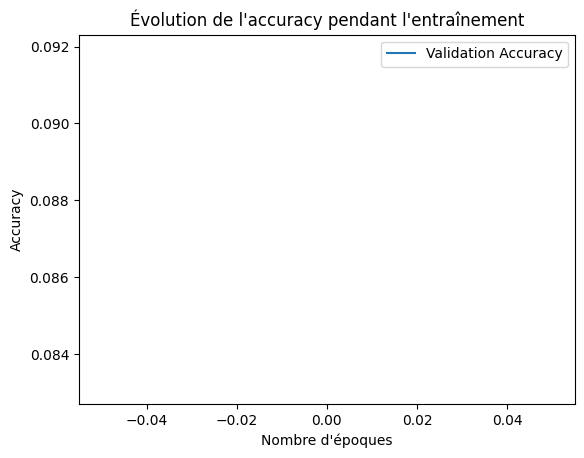

In [71]:
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.metrics.distance import edit_distance

# Définir une classe de rappel pour calculer et enregistrer l'accuracy à chaque époque
class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        # Validation Accuracy
        validation_data = next(self.validation_data)
        predictions = self.model.predict(validation_data[0])
        decoded = tf.keras.backend.ctc_decode(predictions, [75, 75], greedy=False)[0][0].numpy()
        ground_truth = validation_data[1]

        accuracy = compute_accuracy_letter_by_letter(decoded, ground_truth)
        print(f'Validation Accuracy at epoch {epoch + 1}: {accuracy * 100:.2f}%')
        self.accuracies.append(accuracy)

# Fonction pour calculer l'accuracy lettre par lettre
def compute_accuracy_letter_by_letter(preds, truths):
    total_letters = 0
    correct_letters = 0

    for pred, truth in zip(preds, truths):
        for p, t in zip(pred, truth):
            total_letters += 1
            if p == t:
                correct_letters += 1

    accuracy = correct_letters / total_letters if total_letters > 0 else 0
    return accuracy

# Chargement des données (assurez-vous de définir la fonction mappable_function)
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# Division des données en ensembles d'entraînement et de test
train_size = 450
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Création des lots (batches) de données
train_data = train_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
test_data = test_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# Préchargement des données
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)



# Utiliser la fonction de perte CTCLoss avec le rappel AccuracyCallback
model.compile(optimizer='adam', loss=CTCLoss)  # Utilisation de votre fonction de perte personnalisée

accuracy_callback = AccuracyCallback(validation_data=test_data)

history = model.fit(train_data, validation_data=test_data, epochs=50, callbacks=[accuracy_callback])

# Plotter les courbes d'accuracy
plt.plot(accuracy_callback.accuracies, label='Validation Accuracy')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'accuracy pendant l\'entraînement')
plt.legend()
plt.show()
